In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
#from google.colab.patches import cv2_imshow
import skimage.exposure
import os

In [2]:
train=pd.read_csv("TTraining_set.csv")
train.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [3]:
test=pd.read_csv("TTesting_set.csv")
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [4]:
sub=pd.read_csv("ssample_submission.csv")

In [5]:
print("len of training set", len(train))
print("len of testing set", len(test))

len of training set 5724
len of testing set 1908


In [6]:
(train["label"].value_counts())

label
Density2Malignant    1728
Density1Malignant    1620
Density3Benign        702
Density1Benign        648
Density3Malignant     432
Density4Benign        324
Density2Benign        216
Density4Malignant      54
Name: count, dtype: int64

/Users/shreyachinamilli/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shreyachinamilli/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/shreyachinamilli/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Density3Benign'),
  Text(1, 0, 'Density1Benign'),
  Text(2, 0, 'Density1Malignant'),
  Text(3, 0, 'Density4Benign'),
  Text(4, 0, 'Density2Malignant'),
  Text(5, 0, 'Density3Malignant'),
  Text(6, 0, 'Density2Benign'),
  Text(7, 0, 'Density4Malignant')])

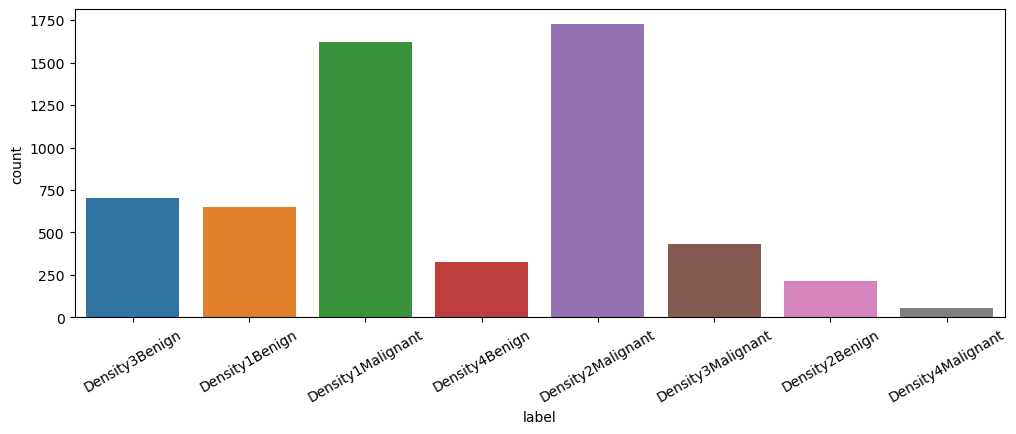

In [7]:
plt.figure(figsize=(12,4))
sns.countplot(x=train["label"],data=train,)
plt.xticks(rotation=30)

In [8]:
train[train["label"]=="Density3Benign"]

,filename,label
0,Image_1.jpg,Density3Benign
6,Image_7.jpg,Density3Benign
19,Image_20.jpg,Density3Benign
24,Image_25.jpg,Density3Benign
33,Image_34.jpg,Density3Benign
...,...,...
5690,Image_5691.jpg,Density3Benign
5705,Image_5706.jpg,Density3Benign
5715,Image_5716.jpg,Density3Benign
5717,Image_5718.jpg,Density3Benign


In [9]:
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

In [10]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [11]:
print("len of training set", len(X_train))
print("len of validation set", len(X_valid))

len of training set 5151
len of validation set 573


In [12]:
datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess)

In [13]:
train_generator=datagen.flow_from_dataframe(
dataframe=X_train,
directory="mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 5151 validated image filenames belonging to 8 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
(224, 224, 3)


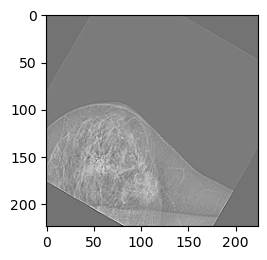

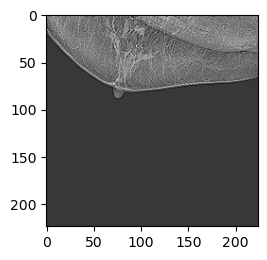

In [14]:
x,y = train_generator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

In [15]:
valid_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
valid_generator=valid_datagen.flow_from_dataframe( 
dataframe=X_valid,
directory="mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 573 validated image filenames belonging to 8 classes.


In [16]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
import os

# Define the directory path
checkpoint_dir = "training_4"

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the checkpoint file path
checkpoint_path = os.path.join(checkpoint_dir, "cp.ckpt")


open(checkpoint_path, 'a').close()

# Now, you have created the "training_0" directory and the "cp.ckpt" file


In [18]:
checkpoint_path = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
               EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [20]:
def build_model():
  model = Sequential()

  conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(8, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

In [21]:
my_model=build_model()

In [22]:
# Define a constant learning rate
learning_rate = 0.00001

# Create the legacy Adam optimizer with the constant learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

# Compile your model
my_model.compile(
    optimizer=optimizer,
    metrics=["accuracy"],
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
)

In [23]:
# Continue with model training
my_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=25,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[my_callbacks]
)

Epoch 1/25


2023-11-04 15:51:42.037706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-04 15:51:42.048868: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - ETA: 0s - loss: 757.9980 - accuracy: 0.2776

2023-11-04 16:15:29.479794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.20404, saving model to training_4/cp.ckpt
160/160 [==============================] - 1457s 9s/step - loss: 757.9980 - accuracy: 0.2776 - val_loss: 729.4324 - val_accuracy: 0.2040 - lr: 1.0000e-05
Epoch 2/25
160/160 [==============================] - ETA: 0s - loss: 700.7278 - accuracy: 0.6533
Epoch 2: val_accuracy improved from 0.20404 to 0.36213, saving model to training_4/cp.ckpt
160/160 [==============================] - 1517s 9s/step - loss: 700.7278 - accuracy: 0.6533 - val_loss: 673.5195 - val_accuracy: 0.3621 - lr: 1.0000e-05
Epoch 3/25
160/160 [==============================] - ETA: 0s - loss: 645.4045 - accuracy: 0.8515
Epoch 3: val_accuracy improved from 0.36213 to 0.51838, saving model to training_4/cp.ckpt
160/160 [==============================] - 1437s 9s/step - loss: 645.4045 - accuracy: 0.8515 - val_loss: 618.9259 - val_accuracy: 0.5184 - lr: 1.0000e-05
Epoch 4/25
160/160 [==============================] - ETA: 0s - loss: 5

In [24]:
my_model.evaluate(valid_generator,verbose=1)

2023-11-05 08:52:22.380910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 23s 1s/step - loss: 3.4151 - accuracy: 0.9738


[3.4150805473327637, 0.9738219976425171]

In [25]:
train_generator.class_indices

{'Density1Benign': 0,
 'Density1Malignant': 1,
 'Density2Benign': 2,
 'Density2Malignant': 3,
 'Density3Benign': 4,
 'Density3Malignant': 5,
 'Density4Benign': 6,
 'Density4Malignant': 7}

In [26]:
test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="mammography_images/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1908 validated image filenames.


In [27]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

2023-11-05 08:53:05.863323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1908/1908 [==============================] - 147s 76ms/step


In [28]:
pred1

array([4, 0, 3, ..., 3, 3, 3])

In [29]:
sub["label"]=pred1
sub["label"]=sub["label"].map({0:'Density1Benign',
 1:'Density1Malignant',
 2:'Density2Benign',
 3:'Density2Malignant',
 4: 'Density3Benign',
 5: 'Density3Malignant',
 6:'Density4Benign',
 7:  'Density4Malignant'})

In [30]:
# Specify the file path
file_path = '12.csv'

# Open the file in write mode, which creates an empty file
with open(file_path, 'w') as f:
    pass


In [31]:
sub.to_csv("12.csv",index=False)

In [32]:
my_model.save("model_4/model_4.h5")

In [33]:
my_model.save("weights_4/modeldense4.h5")